<a href="https://colab.research.google.com/github/mchivuku/deep-learning-e533/blob/master/Homework_3_RNN_Speech_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Masters-DS/Deep\ Learning\ -\ E533/
%cd Homework3


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Masters-DS/Deep Learning - E533
/content/drive/My Drive/Masters-DS/Deep Learning - E533/Homework3


## Install Libraries

In [0]:
# Install librosa and other audio libraries

%%capture
!apt install ffmpeg
!pip install tensorpack
!pip install pydub
!pip install pysoundfile
!pip install librosa


!pip install livelossplot


## Import Libraries

In [12]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Plot libraries
import matplotlib.pyplot as plt

%matplotlib inline

import torch.optim as optim

## Plotting library

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d


from livelossplot import PlotLosses


print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )





Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


## Helper functions

In [0]:
import librosa.display
import numpy as np
import torch.nn
from IPython.display import display, Audio
from livelossplot import PlotLosses
import librosa

## Load all the files
def convert_to_stft(audio):
  S=librosa.stft(audio, n_fft=1024, hop_length=512)
  return S

'''
Load .wav file
'''
def load_wav(path, sr=None):
    s, sr=librosa.load(path, sr=None)
    return (s, sr)

## Load Data

In [0]:
"""
Load files, perform stft
"""
def build_spectogram_inputs(dir, files):
  tn = []
  ts = []
  tx = []
  s_audio_list = []
  
  tn_abs = []
  ts_abs = []
  tx_abs = []
  
  cnt = 0
  for filename in files:
    (audio, sr)  = load_wav(os.path.join(dir,filename))
    
    
    S = convert_to_stft(audio)
    S = S.T
    ## Third character
    s_with = os.path.splitext(filename)[0][-5:]
    
    
    ## startswith n
    if s_with.startswith("n"):
      tn.append(S)
      tn_abs.append(np.abs(S))
      
    elif s_with.startswith("s"):
      ts.append(S)
      ts_abs.append(np.abs(S))
      s_audio_list.append(audio)
      
    else:
      tx.append(S)
      tx_abs.append(np.abs(S))
      
      
  return (s_audio_list, ts, ts_abs, tn, tn_abs, tx, tx_abs)

    
"""
IBM
"""
def IBM_mask(S_seq, N_seq):
  M = []
  for i in range(len(S_seq)):
    S_matrix = S_seq[i]
    N_matrix = N_seq[i]
    
    M_matrix = np.where(S_matrix>N_matrix,1,0)
  
    M.append(M_matrix)
    
  return M
    

In [16]:
import os
train_dir = os.path.join('timit-homework','tr')
test_dir = os.path.join("timit-homework","te")
val_dir = os.path.join("timit-homework","v")

files = [filename for filename in os.listdir(train_dir)]
sorted_files = sorted(files, key=lambda x: int(os.path.splitext(x)[0][-4:]))

validation_files = [filename for filename in os.listdir(val_dir)]
test_files = [filename for filename in os.listdir(test_dir)]

sorted_validation = sorted(validation_files, key=lambda x: int(os.path.splitext(x)[0][-4:]))
sorted_test = sorted(test_files, key=lambda x: int(os.path.splitext(x)[0][-4:]))

print(f"No of train files:{len(sorted_files)}, validation files:{len(validation_files)}, test files:{len(test_files)}")


No of train files:3600, validation files:3600, test files:400


In [9]:
## Load Train
(train_audio_list, train_s, trains_abs, train_n, train_n_abs, train_x, train_x_abs) = build_spectogram_inputs(train_dir,sorted_files)
print("Train completed")

# Load Validation
(val_audio_list, val_s, val_s_abs, val_n, val_n_abs, val_x, val_x_abs) = build_spectogram_inputs(val_dir, sorted_validation)

print("Validation completed ")

## Load Test
(test_audio_list, test_s, test_s_abs, test_n, test_n_abs, test_x, test_x_abs) = build_spectogram_inputs(test_dir, sorted_test)
print("Test completed")




Train completed
Validation completed 
Test completed


(1200, (65, 513), (130, 513))

In [18]:
len(val_audio_list)

1200

In [0]:
def transpose_x(x):
  o = []
  for i in range(len(x)):
    o.append(x[i].T)
    
  return o

#train_x = transpose_x(train_x)
#val_x = transpose_x(val_x)
#test_x = transpose_x(test_x)
#train_x_abs = transpose_x(train_x_abs)
#val_x_abs = transpose_x(val_x_abs)
train_x_abs[0].shape


(65, 513)

In [0]:
## Truncate train_x, valu_x
seq_len = 39
def truncate(x):
  shapes = []
  for i in range(len(x)):
    shapes.append(x[i].shape[0])
    
  min_t = seq_len
  
  o = []
  for i in range(len(x)):
    v = x[i]
    o.append(v[:min_t,])
    
  return o


### Build M matrix - train, validation and test

In [0]:
M_train = IBM_mask(trains_abs,train_n_abs)
M_val = IBM_mask(val_s_abs,val_n_abs)


In [0]:
print(f"len of mask, {len(M_train),len(M_val)}")
train_x[0].shape, M_train[0].shape,train_x_abs[9].shape


len of mask, (1200, 1200)


((65, 513), (65, 513), (65, 513))

### Function to perform inverse ISFT and compute SNR

In [0]:
import math
def inverse_stft_snr(M_predicted, X, s, i):
    M_predicted = M_predicted.T
    s_hat = M_predicted * X[:,:M_predicted.shape[1]]
   
    s_hat = librosa.istft(s_hat, win_length = 1024, hop_length = 512)
    
    nlen = min(len(s), len(s_hat))
    SNR = 10*math.log10((np.sum(s[:nlen]**2))/(np.sum((s[:nlen] - s_hat[:nlen])**2)))
    #print("SNR: {:.2f}".format(SNR))
    return SNR

## Running Average Class - Compute Average loss or accuracy over epoch

In [0]:
class RunningAverage ():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )

## Build RNN Model

In [0]:
# Recurrent neural network (many-to-many)
class SimpleRNN(nn.Module):
  def __init__(self, input_dimensions = 513,hidden_dimensions = 128, num_layers = 2, num_classes = 513, 
               dropout=0.5, batch_first = True, bidirectional = False, seq_len = 39):
    super(SimpleRNN, self).__init__()
    self.input_dim = input_dimensions
    self.hidden_dim = hidden_dimensions
    self.num_classes = num_classes
    
    self.num_layers = 2
    self.dropout = dropout
    
    self.batch_first = True
    self.bidirectional = bidirectional
    
    self.seq_len = seq_len
    
    ## GRU Layer
    self.gru  = nn.GRU(input_size = self.input_dim, hidden_size = self.hidden_dim,num_layers =  self.num_layers, batch_first = True,
                      dropout = self.dropout, bidirectional = self.bidirectional)
    
    ## fully connected layer
    self.fc = nn.Linear(in_features = self.hidden_dim, out_features = self.num_classes)
    
  """
  Forward propagate
  """
  def forward(self,X):
    assert len(X.size()) == 3 ## Input dimensions must be of length 3
    
    batch_index = 0 if self.batch_first else 1
    num_direction = 2 if self.bidirectional else 1
    
    ## hidden state in first sequence of the GRU
    h_0 = Variable(torch.zeros([self.num_layers, 10, self.hidden_dim]))

    ## next hidden state
    output_gru, h_n = self.gru(X,h_0)
    
    ## Linear states opereates on the last dimension of its input
    # i.e. for each size [i,j,:] for gru output it produces a a vector of size num classes
    
    ## # fc_output will be batch_size*seq_len*num_classes
    out = self.fc(output_gru)
    return torch.sigmoid(out)
    
    
model = SimpleRNN()


## Training the Network

In [84]:
import torch
import torch.nn as nn
from torch.autograd import Variable


X_abs = (train_x_abs)
M = (M_train)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.BCELoss()


## Training
num_epochs = 20
mini_batchsize = 10
train_losses = []
val_snr_values = []
input_size  = 513
for epoch in range(num_epochs):
    
    epoch_loss = RunningAverage()
    ## Model train
    model.train()
    
    # shuffle inputs
    train_indices = np.arange(0,1200,mini_batchsize)
    np.random.shuffle(train_indices)
    
    for i in range(len(train_indices)):
      
      ## inputs
      start = int(train_indices[i])
      
      train_inp = np.array(X_abs[start:start+mini_batchsize])
      train_out = np.array((M[start:start+mini_batchsize]))
      train_inp = np.array(truncate(train_inp))
      train_out = np.array(truncate(train_out))
      
      
      train_inp = torch.from_numpy(train_inp).float()
      train_out = torch.from_numpy(train_out).float()
      # Forward pass
      pred = model(train_inp)
     
      # Backward and optimize
      optimizer.zero_grad()
      loss = loss_func(pred, train_out)
      loss.backward()
      optimizer.step()
      
      
      if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(train_indices), loss.item()))
          
      epoch_loss.update(loss.item())
    train_losses.append(epoch_loss())
    
    ## Validation
    model.eval()
    snr_values = []
    vi = 0
    while vi+mini_batchsize<len(val_x_abs):
      val_input = np.array(val_x_abs[vi:vi+mini_batchsize])
      val_output = np.zeros((mini_batchsize, val_x_abs[i].shape[0], val_x_abs[i].shape[1]))
      val_input = np.array(truncate(val_input))
      val_output = np.array(truncate(val_output))
      
      
      val_input, val_output = Variable( torch.from_numpy(val_input)), Variable(torch.from_numpy(val_output))
      pred = model(val_input)
      
      snr_values.append(inverse_stft_snr(pred[0,:,:].detach().cpu().numpy(),val_x[vi].T, val_audio_list[vi],vi))
      vi+=1
      
    val_snr_values.append(np.mean(snr_values))
    
    if np.mean(snr_values)>=10:
      break
      
print("MEAN SNR",np.mean(snr_values))

Epoch [1/20], Step [100/120], Loss: 0.5487
Epoch [2/20], Step [100/120], Loss: 0.5018
Epoch [3/20], Step [100/120], Loss: 0.5173
Epoch [4/20], Step [100/120], Loss: 0.4773
Epoch [5/20], Step [100/120], Loss: 0.5269
Epoch [6/20], Step [100/120], Loss: 0.4638
Epoch [7/20], Step [100/120], Loss: 0.5248
Epoch [8/20], Step [100/120], Loss: 0.4914
Epoch [9/20], Step [100/120], Loss: 0.4438
Epoch [10/20], Step [100/120], Loss: 0.4272
Epoch [11/20], Step [100/120], Loss: 0.4115
Epoch [12/20], Step [100/120], Loss: 0.4510
Epoch [13/20], Step [100/120], Loss: 0.4489
Epoch [14/20], Step [100/120], Loss: 0.4207
Epoch [15/20], Step [100/120], Loss: 0.4001
Epoch [16/20], Step [100/120], Loss: 0.4207
Epoch [17/20], Step [100/120], Loss: 0.4568
Epoch [18/20], Step [100/120], Loss: 0.3947
Epoch [19/20], Step [100/120], Loss: 0.3959
Epoch [20/20], Step [100/120], Loss: 0.4078
MEAN SNR 9.485835280758069


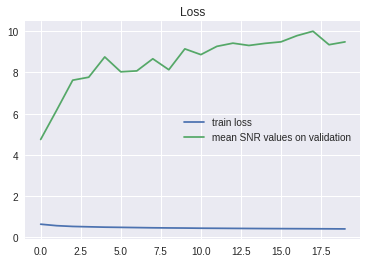

MEAN SNR 9.485835280758069


In [85]:
plt.plot(np.arange(epoch+1),train_losses)
plt.plot(np.arange(epoch+1),val_snr_values)
plt.title("Loss")
plt.legend(["train loss","mean SNR values on validation"])
plt.show()

print("MEAN SNR",np.mean(snr_values))


In [0]:

def save_recovered_source(M_predicted,x,i):
    M_predicted = M_predicted.T
    s_hat = M_predicted * x[:,:M_predicted.shape[1]]
    
    s_hat = librosa.istft(s_hat, win_length = 1024, hop_length = 512)
    sr = 16000
    librosa.output.write_wav(f'recovered/test_recovered_{i}s.wav', s_hat, sr)
    
model.eval()
with torch.no_grad():
  index = 0
  while i+mini_batchsize<len(test_x_abs):
    test_input = np.array(test_x_abs[i:i+mini_batchsize])
    test_input = np.array(truncate(test_input))
    
    input = Variable(torch.from_numpy(test_input))
    
    pred = model(input)
    
    ## reconstructed test signal
    save_recovered_source(pred[0,:,:].detach().cpu().numpy(),test_x[i].T,i)
    i+=1
      
    

In [0]:
print(len(test_x_abs))

400


39
